# Multi-Head Attention Mechanism

This notebook demonstrates the Multi-Head Attention mechanism, a core component of Transformer architectures.

We'll cover:
1. Scaled Dot-Product Attention
2. Multi-Head Attention implementation from scratch
3. PyTorch's built-in MultiheadAttention
4. Practical examples and visualizations

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Scaled Dot-Product Attention

The fundamental building block of multi-head attention:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [2]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        query: Query tensor of shape (batch_size, seq_len, d_k)
        key: Key tensor of shape (batch_size, seq_len, d_k)
        value: Value tensor of shape (batch_size, seq_len, d_v)
        mask: Optional mask tensor
    
    Returns:
        output: Attention output of shape (batch_size, seq_len, d_v)
        attention_weights: Attention weights of shape (batch_size, seq_len, seq_len)
    """
    d_k = query.size(-1)
    
    # Compute attention scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply attention weights to values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

# Test scaled dot-product attention
batch_size = 2
seq_len = 4
d_k = 8
d_v = 8

Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_v)

output, attn_weights = scaled_dot_product_attention(Q, K, V)

print(f"Query shape: {Q.shape}")
print(f"Key shape: {K.shape}")
print(f"Value shape: {V.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

Query shape: torch.Size([2, 4, 8])
Key shape: torch.Size([2, 4, 8])
Value shape: torch.Size([2, 4, 8])
Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 4, 4])


## 3. Visualize Attention Weights

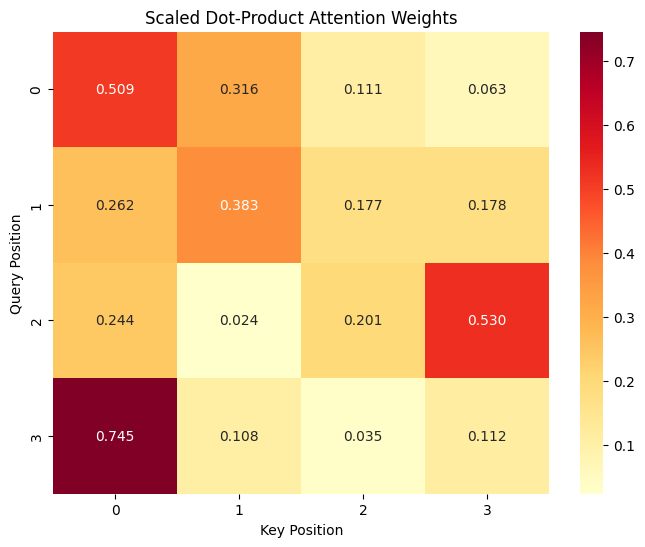

In [3]:
def visualize_attention(attention_weights, title="Attention Weights"):
    """Visualize attention weights as a heatmap."""
    # Take first sample from batch
    attn = attention_weights[0].detach().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, annot=True, fmt='.3f', cmap='YlOrRd', cbar=True)
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title(title)
    plt.show()

visualize_attention(attn_weights, "Scaled Dot-Product Attention Weights")

## 4. Multi-Head Attention Implementation

Multi-head attention allows the model to attend to different representation subspaces:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where $\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism from scratch.
    """
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        """
        Args:
            d_model: Dimension of the model
            num_heads: Number of attention heads
            dropout: Dropout probability
        """
        super().__init__()
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def split_heads(self, x):
        """
        Split the last dimension into (num_heads, d_k).
        Transpose to shape: (batch_size, num_heads, seq_len, d_k)
        """
        batch_size, seq_len, d_model = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        """
        Combine heads back to original shape.
        Input shape: (batch_size, num_heads, seq_len, d_k)
        Output shape: (batch_size, seq_len, d_model)
        """
        batch_size, num_heads, seq_len, d_k = x.size()
        x = x.transpose(1, 2).contiguous()
        return x.view(batch_size, seq_len, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        """
        Forward pass.
        
        Args:
            query: Query tensor of shape (batch_size, seq_len, d_model)
            key: Key tensor of shape (batch_size, seq_len, d_model)
            value: Value tensor of shape (batch_size, seq_len, d_model)
            mask: Optional mask tensor
        
        Returns:
            output: Attention output of shape (batch_size, seq_len, d_model)
            attention_weights: Attention weights
        """
        batch_size = query.size(0)
        
        # Linear projections
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Split into multiple heads
        Q = self.split_heads(Q)  # (batch_size, num_heads, seq_len, d_k)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Compute attention for each head
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        attention_output = torch.matmul(attention_weights, V)
        
        # Combine heads
        attention_output = self.combine_heads(attention_output)
        
        # Final linear projection
        output = self.W_o(attention_output)
        
        return output, attention_weights

# Create multi-head attention module
d_model = 512
num_heads = 8
mha = MultiHeadAttention(d_model, num_heads)

print(f"Multi-Head Attention Module:")
print(f"  d_model: {d_model}")
print(f"  num_heads: {num_heads}")
print(f"  d_k (dimension per head): {d_model // num_heads}")
print(f"\nTotal parameters: {sum(p.numel() for p in mha.parameters()):,}")

Multi-Head Attention Module:
  d_model: 512
  num_heads: 8
  d_k (dimension per head): 64

Total parameters: 1,050,624


## 5. Test Multi-Head Attention

In [5]:
# Create sample input
batch_size = 2
seq_len = 10
d_model = 512

x = torch.randn(batch_size, seq_len, d_model)

print(f"Input shape: {x.shape}")

# Self-attention (Q, K, V are all the same)
mha.eval()
with torch.no_grad():
    output, attn_weights = mha(x, x, x)

print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  (batch_size, num_heads, seq_len, seq_len)")

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])
  (batch_size, num_heads, seq_len, seq_len)


## 6. Visualize Multi-Head Attention

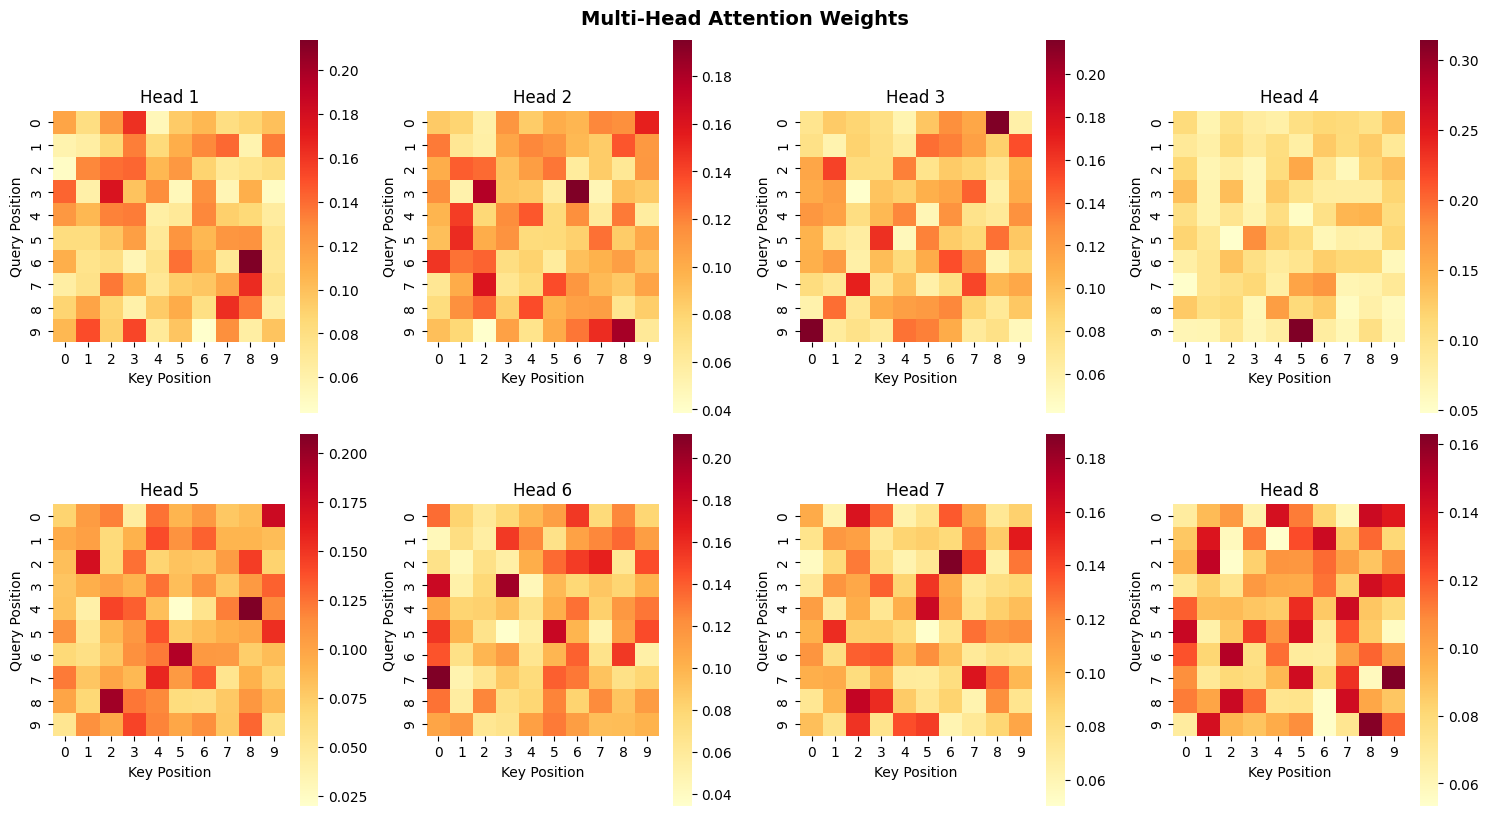

In [6]:
def visualize_multihead_attention(attention_weights, num_heads_to_show=4):
    """
    Visualize attention weights from multiple heads.
    """
    # Take first sample from batch
    attn = attention_weights[0].detach().numpy()  # (num_heads, seq_len, seq_len)
    
    num_heads = min(num_heads_to_show, attn.shape[0])
    
    fig, axes = plt.subplots(2, num_heads // 2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(num_heads):
        ax = axes[i]
        sns.heatmap(attn[i], ax=ax, cmap='YlOrRd', cbar=True, square=True)
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        ax.set_title(f'Head {i+1}')
    
    plt.tight_layout()
    plt.suptitle('Multi-Head Attention Weights', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

# Visualize attention from multiple heads
visualize_multihead_attention(attn_weights, num_heads_to_show=8)

## 7. Compare with PyTorch's Built-in MultiheadAttention

In [7]:
# PyTorch's built-in MultiheadAttention
pytorch_mha = nn.MultiheadAttention(
    embed_dim=d_model,
    num_heads=num_heads,
    dropout=0.1,
    batch_first=True  # Use batch_first=True for (batch, seq, feature) format
)

print("PyTorch's MultiheadAttention:")
print(pytorch_mha)
print(f"\nTotal parameters: {sum(p.numel() for p in pytorch_mha.parameters()):,}")

# Test PyTorch's implementation
pytorch_mha.eval()
with torch.no_grad():
    pytorch_output, pytorch_attn_weights = pytorch_mha(x, x, x)

print(f"\nPyTorch output shape: {pytorch_output.shape}")
print(f"PyTorch attention weights shape: {pytorch_attn_weights.shape}")

PyTorch's MultiheadAttention:
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
)

Total parameters: 1,050,624

PyTorch output shape: torch.Size([2, 10, 512])
PyTorch attention weights shape: torch.Size([2, 10, 10])


## 8. Practical Example: Sentence Attention

In [8]:
# Simple example with meaningful tokens
def create_sentence_example():
    """Create a simple example with interpretable attention."""
    # Simulate embeddings for a simple sentence
    # "The cat sat on the mat"
    seq_len = 6
    d_model = 64
    
    # Create simple embeddings with some structure
    embeddings = torch.randn(1, seq_len, d_model)
    
    # Make some positions more similar to demonstrate attention
    embeddings[0, 1] = embeddings[0, 1] + 0.5 * embeddings[0, 4]  # "cat" attends to "the"
    embeddings[0, 2] = embeddings[0, 2] + 0.5 * embeddings[0, 5]  # "sat" attends to "mat"
    
    return embeddings

# Create example
sentence_embeddings = create_sentence_example()
words = ["The", "cat", "sat", "on", "the", "mat"]

# Create a smaller multi-head attention for visualization
small_mha = MultiHeadAttention(d_model=64, num_heads=4)
small_mha.eval()

with torch.no_grad():
    output, attn_weights = small_mha(sentence_embeddings, sentence_embeddings, sentence_embeddings)

print(f"Sentence: {' '.join(words)}")
print(f"Output shape: {output.shape}")

Sentence: The cat sat on the mat
Output shape: torch.Size([1, 6, 64])


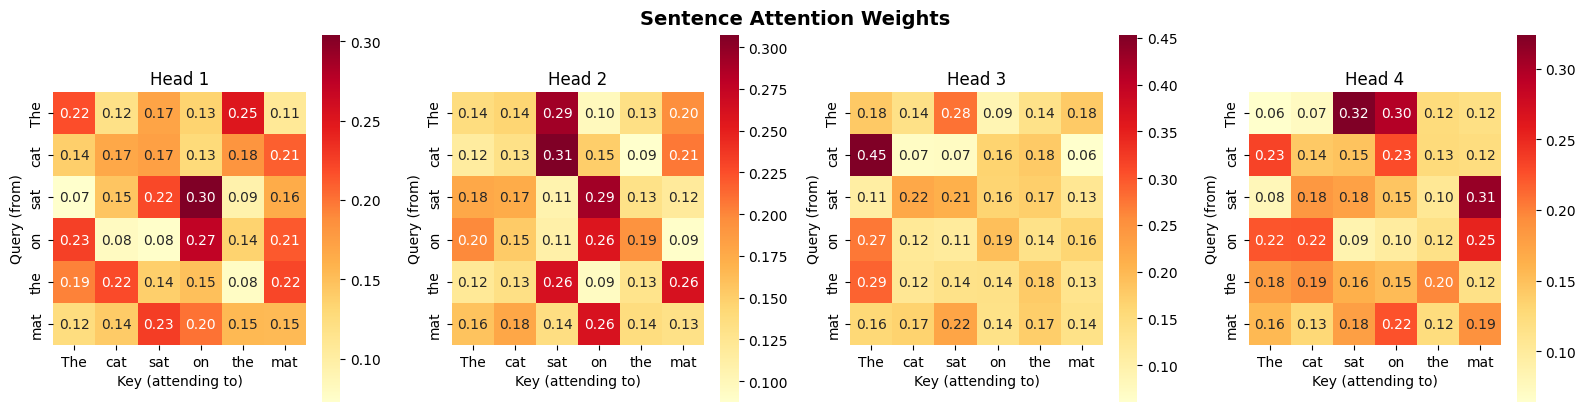

In [9]:
# Visualize attention for the sentence
def visualize_sentence_attention(attention_weights, words, num_heads_to_show=4):
    """Visualize attention weights with word labels."""
    attn = attention_weights[0].detach().numpy()
    num_heads = min(num_heads_to_show, attn.shape[0])
    
    fig, axes = plt.subplots(1, num_heads, figsize=(16, 4))
    
    for i in range(num_heads):
        ax = axes[i]
        sns.heatmap(
            attn[i],
            ax=ax,
            cmap='YlOrRd',
            cbar=True,
            xticklabels=words,
            yticklabels=words,
            square=True,
            annot=True,
            fmt='.2f'
        )
        ax.set_xlabel('Key (attending to)')
        ax.set_ylabel('Query (from)')
        ax.set_title(f'Head {i+1}')
    
    plt.tight_layout()
    plt.suptitle('Sentence Attention Weights', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

visualize_sentence_attention(attn_weights, words, num_heads_to_show=4)

## 9. Masked Multi-Head Attention (for Decoders)

Causal Mask (prevents attention to future positions):


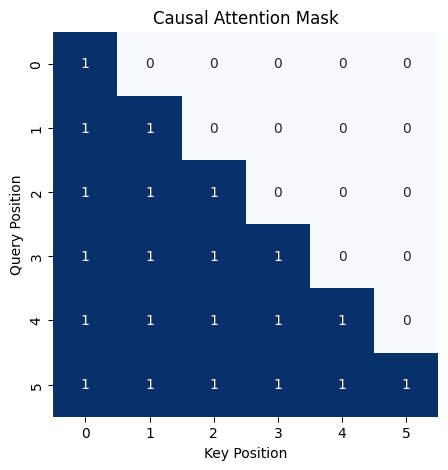


Masked attention output shape: torch.Size([1, 6, 64])


In [10]:
def create_causal_mask(seq_len):
    """
    Create a causal mask to prevent attention to future positions.
    Used in decoder self-attention.
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions

# Create causal mask
seq_len = 6
causal_mask = create_causal_mask(seq_len)

print("Causal Mask (prevents attention to future positions):")
plt.figure(figsize=(6, 5))
sns.heatmap(causal_mask[0, 0].numpy(), annot=True, cmap='Blues', cbar=False, square=True)
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Causal Attention Mask')
plt.show()

# Apply masked attention
with torch.no_grad():
    masked_output, masked_attn = small_mha(sentence_embeddings, sentence_embeddings, sentence_embeddings, mask=causal_mask)

print(f"\nMasked attention output shape: {masked_output.shape}")

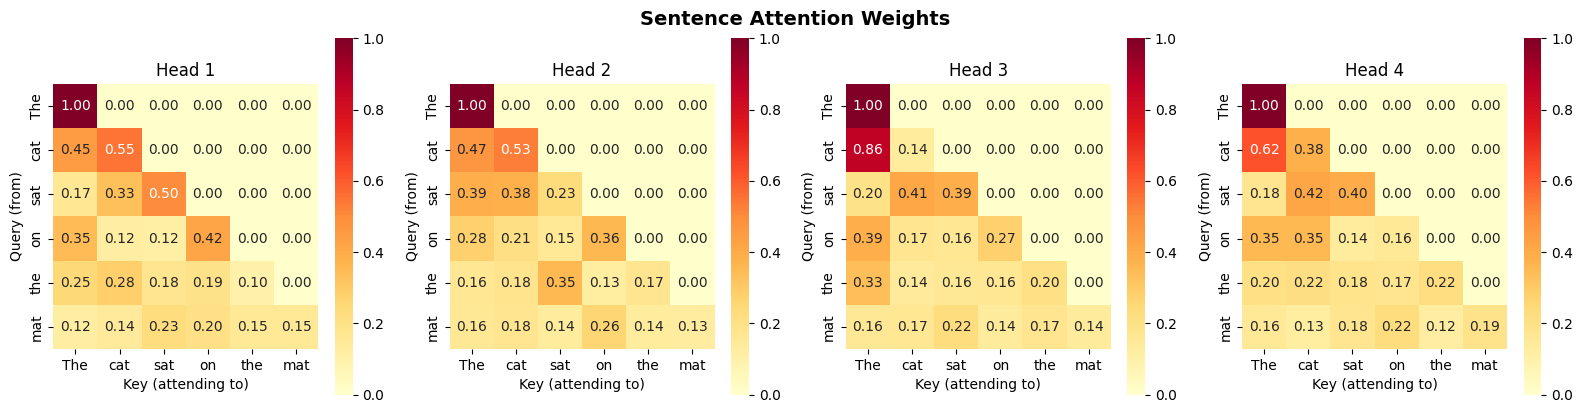

In [11]:
# Visualize masked attention
visualize_sentence_attention(masked_attn, words, num_heads_to_show=4)

## 10. Key Properties of Multi-Head Attention

In [12]:
print("Key Properties of Multi-Head Attention:")
print("="*60)

print("\n1. Multiple Representation Subspaces:")
print("   - Each head learns different attention patterns")
print("   - Captures different aspects of relationships")
print("   - Increases model capacity and expressiveness")

print("\n2. Parallel Processing:")
print("   - All heads computed in parallel")
print("   - Efficient on modern hardware (GPUs/TPUs)")
print("   - No sequential dependencies")

print("\n3. Permutation Invariance:")
print("   - Attention is permutation equivariant")
print("   - Position information must be added separately")
print("   - Usually via positional encodings")

print("\n4. Variable Length Sequences:")
print("   - Can handle sequences of any length")
print("   - No recurrence required")
print("   - Enables efficient batching")

print("\n5. Interpretability:")
print("   - Attention weights can be visualized")
print("   - Shows which positions model focuses on")
print("   - Helps understand model behavior")

print("="*60)

print("\nComputational Complexity:")
print("="*60)
print(f"  Time: O(n² · d) where n=seq_len, d=d_model")
print(f"  Space: O(n² + n·d)")
print(f"  Quadratic in sequence length")
print("="*60)

Key Properties of Multi-Head Attention:

1. Multiple Representation Subspaces:
   - Each head learns different attention patterns
   - Captures different aspects of relationships
   - Increases model capacity and expressiveness

2. Parallel Processing:
   - All heads computed in parallel
   - Efficient on modern hardware (GPUs/TPUs)
   - No sequential dependencies

3. Permutation Invariance:
   - Attention is permutation equivariant
   - Position information must be added separately
   - Usually via positional encodings

4. Variable Length Sequences:
   - Can handle sequences of any length
   - No recurrence required
   - Enables efficient batching

5. Interpretability:
   - Attention weights can be visualized
   - Shows which positions model focuses on
   - Helps understand model behavior

Computational Complexity:
  Time: O(n² · d) where n=seq_len, d=d_model
  Space: O(n² + n·d)
  Quadratic in sequence length


## Summary

This notebook demonstrated:

1. **Scaled Dot-Product Attention**: The fundamental attention mechanism
2. **Multi-Head Attention**: Implementation from scratch and PyTorch's version
3. **Attention Visualization**: Heatmaps showing attention patterns
4. **Practical Examples**: Sentence-level attention with interpretable results
5. **Masked Attention**: Causal masking for decoder applications

Key concepts:
- **Query, Key, Value**: Three learned projections of the input
- **Attention Scores**: Similarity between queries and keys
- **Attention Weights**: Normalized scores (softmax)
- **Multi-Head**: Multiple attention mechanisms in parallel
- **Masking**: Control which positions can attend to each other

Applications:
- Transformers (BERT, GPT, T5, etc.)
- Machine translation
- Language modeling
- Vision Transformers (ViT)
- Any sequence-to-sequence tasks